## Packages

In [1]:
# Drive configuration
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [2]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
import numpy as np
import PIL.Image
from PIL import Image
#import scipy.misc

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

#from resnets_utils import *
#from test_utils import summary, comparator
#import public_tests

#from matplotlib.pyplot import imshow
#%matplotlib inline

2021-08-25 16:12:23.228359: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Identity block implementation
### Does not change input dimensions.

In [4]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    assert len(filters) == 3, "You must send three number of convolutional filters."
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

## Convolutional Block

In [5]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window kernel_filter for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## ResNet Achitecture (50 Layers)

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

In [6]:
# UNQ_C3
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (256, 256, 1), classes = 4):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)  
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256,256,1024], s = 2)
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])
    X = identity_block(X, 3, [256,256,1024])

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512,512,2048], s = 2)
    X = identity_block(X, 3, [512,512,2048])
    X = identity_block(X, 3, [512,512,2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [7]:
model = ResNet50(input_shape = (256, 256, 1), classes = 4)
print(model.summary())

2021-08-25 16:12:24.446978: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-08-25 16:12:24.499435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 269.00GiB/s
2021-08-25 16:12:24.499517: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-08-25 16:12:24.503826: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-08-25 16:12:24.507723: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-08-25 16:12:24.508393: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
20

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
_______________________________________________________________________________________

## Configure the learning process by compiling the model.

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Let's load the COVID dataset. Using image.ImageDataGenerator


In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)
directory = "/home/9679247/Documentos/Doutorado/CNN-For-Covid/COVID-19_Radiography_Dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             color_mode='grayscale',
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             color_mode='grayscale',
                                             subset='validation',
                                             seed=42)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [11]:
'''BATCH_SIZE = 32
IMG_SIZE = (256, 256)
directory = '/home/9679247/Documentos/Doutorado/CNN-For-Covid/COVID-19_Radiography_Dataset'
train_dataset = image.ImageDataGenerator(validation_split=0.2).flow_from_directory(
                                             directory,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMG_SIZE,
                                             color_mode='grayscale', 
                                             subset='training',
                                             seed=42)
validation_dataset = image.ImageDataGenerator(validation_split=0.2).flow_from_directory(
                                             directory,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMG_SIZE,
                                             color_mode='grayscale', 
                                             subset='validation',
                                             seed=42)'''

"BATCH_SIZE = 32\nIMG_SIZE = (256, 256)\ndirectory = '/home/9679247/Documentos/Doutorado/CNN-For-Covid/COVID-19_Radiography_Dataset'\ntrain_dataset = image.ImageDataGenerator(validation_split=0.2).flow_from_directory(\n                                             directory,\n                                             shuffle=False,\n                                             batch_size=BATCH_SIZE,\n                                             target_size=IMG_SIZE,\n                                             color_mode='grayscale', \n                                             subset='training',\n                                             seed=42)\nvalidation_dataset = image.ImageDataGenerator(validation_split=0.2).flow_from_directory(\n                                             directory,\n                                             shuffle=False,\n                                             batch_size=BATCH_SIZE,\n                                             target_size=I

## Let's train the model:

In [13]:
history = model.fit(train_dataset,validation_data=validation_dataset, epochs = 10)

2021-08-25 16:17:44.916637: W tensorflow/core/common_runtime/bfc_allocator.cc:431] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8B (rounded to 256)requested by op Equal
Current allocation summary follows.
2021-08-25 16:17:44.916711: I tensorflow/core/common_runtime/bfc_allocator.cc:970] BFCAllocator dump for GPU_0_bfc
2021-08-25 16:17:44.916739: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (256): 	Total Chunks: 107, Chunks in use: 107. 26.8KiB allocated for chunks. 26.8KiB in use in bin. 14.2KiB client-requested in use in bin.
2021-08-25 16:17:44.916756: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (512): 	Total Chunks: 64, Chunks in use: 64. 32.2KiB allocated for chunks. 32.2KiB in use in bin. 32.0KiB client-requested in use in bin.
2021-08-25 16:17:44.916773: I tensorflow/core/common_runtime/bfc_allocator.cc:977] Bin (1024): 	Total Chunks: 129, Chunks in use: 129. 130.8KiB allocated for chunks. 130.8KiB in use in bin. 129.0KiB client-requeste

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run Equal: Dst tensor is not initialized. [Op:Equal]

bfc_allocator.cc:1026] InUse at 7f3101555b00 of size 2621440 next 216
2021-08-25 16:17:44.922893: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f31017d5b00 of size 2359296 next 215
2021-08-25 16:17:44.922903: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f3101a15b00 of size 2359296 next 233
2021-08-25 16:17:44.922913: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f3101c55b00 of size 1048576 next 256
2021-08-25 16:17:44.922923: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f3101d55b00 of size 1310720 next 250
2021-08-25 16:17:44.922934: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f3101e95b00 of size 2359296 next 249
2021-08-25 16:17:44.922944: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f31020d5b00 of size 1048576 next 274
2021-08-25 16:17:44.922959: I tensorflow/core/common_runtime/bfc_allocator.cc:1026] InUse at 7f31021d5b00 of size 1310720 next 268
2021-08-25 16

In [19]:
history.history

{'loss': [3.881141185760498,
  9.388317108154297,
  1.176963210105896,
  0.6131624579429626,
  0.43527764081954956,
  0.4589264392852783,
  0.3019866943359375,
  0.2837490141391754,
  0.4570746421813965,
  0.3771190941333771],
 'accuracy': [0.9774982333183289,
  0.9329081177711487,
  0.9578313231468201,
  0.9514528512954712,
  0.9451334476470947,
  0.9193243384361267,
  0.9669265151023865,
  0.968875527381897,
  0.9784432053565979,
  0.9498582482337952]}

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

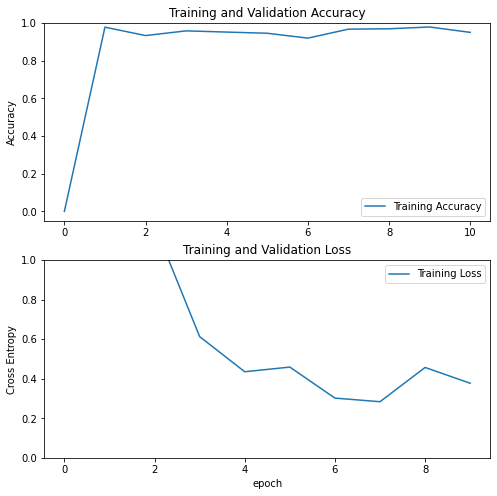

In [22]:
acc = [0.] + history.history['accuracy']
#val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Let's see how this model (trained on only two epochs) performs on the test set.

In [24]:
preds = model.evaluate(validation_dataset)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

133/133 [==============================] - 29s 219ms/step - loss: 10.9536 - accuracy: 0.6823
Loss = 10.95362377166748
Test Accuracy = 0.6822584271430969


**Expected Output**:

<table>
    <tr>
        <td>
            <b>Test Accuracy</b>
        </td>
        <td>
           >0.80
        </td>
    </tr>

</table>

For the purposes of this assignment, you've been asked to train the model for just two epochs. You can see that it performs pretty poorly, but that's ok! The online grader will only run your code for a small number of epochs as well. Please go ahead and submit your assignment as is. 

After you have finished this official (graded) part of this assignment, you can also optionally train the ResNet for more iterations, if you want. It tends to get much better performance when trained for ~20 epochs, but this does take more than an hour when training on a CPU. 

Using a GPU, this ResNet50 model's weights were trained on the SIGNS dataset. You can load and run the trained model on the test set in the cells below. It may take ≈1min to load the model. Have fun! 

In [ ]:
pre_trained_model = tf.keras.models.load_model('resnet50.h5')

In [ ]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

**Congratulations** on finishing this assignment! You've now implemented a state-of-the-art image classification system! Woo hoo! 

ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.

<font color = 'blue'>

**What you should remember**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main types of blocks: The **identity block** and the **convolutional block**. 
- Very deep Residual Networks are built by stacking these blocks together.

<a name='5'></a>  
## 5 - Test on Your Own Image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

In [ ]:
img_path = 'images/my_hand_digit.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))


You can also print a summary of your model by running the following code.

In [ ]:
pre_trained_model.summary()

<a name='6'></a>  
## 6 - Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
